In [89]:
"""
Created on Mon Apr 13 21:23:52 2020

This is the main geosCode used to compute the Stokes elements. 

@author: gouravmahapatr, TU Delft
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate 
import pymiedap.pymiedap as pmd
from getgeos import *
#from ccspline import *
from scipy.ndimage import gaussian_filter

In [90]:
def ccspline(x,y,xint):
    '''
    Constrained cubic spline.
    
    Input:  x,y:  data in which interpolation should be performed.  
            xint: point at which yint is to be found.
    Output: yint
    '''
    # initialize an empty list    
    yint = []
    for i in range(1,len(x)):
        if i == 0:
            raise Exception('i should not be equal to zero!')    
        try: # for cases without a division by zero. 
            if i == (len(x)-1):
                pass # for this case fdxi is evaluated after evaluating fdxim1 
            else:
                fdxi = 2/(((x[i+1]-x[i])/(y[i+1]-y[i]))+((x[i]-x[i-1])/(y[i]-y[i-1])))          # Eqn. (7a)
        except:  # just to set the value to zero in case weird things happen. 
            fdxi = 0

        try:
            if i == 1:
                fdxim1 = 3/2*(y[i]-y[i-1])/(x[i]-x[i-1])-fdxi/2           # Eqn. (7b)
            elif i == (len(x)-1): # this is the case where x is at the end point
                fdxim1 = 2/(((x[i]-x[i-1])/(y[i]-y[i-1]))+((x[i-1]-x[i-1-1])/(y[i-1]-y[i-1-1])))
                fdxi = 3/2*(y[i]-y[i-1])/(x[i]-x[i-1])-fdxim1/2           # Eqn. (7c)
            else:
                fdxim1 = 2/(((x[i]-x[i-1])/(y[i]-y[i-1]))+((x[i-1]-x[i-1-1])/(y[i-1]-y[i-1-1])))           
        except:
            fdxim1 = 0

        try:
            fddxim1 = -2*(fdxi+2*fdxim1)/(x[i]-x[i-1])+6*(y[i]-y[i-1])/(x[i]-x[i-1])**2         # Eqn. (8)
        except:
            fddxim1 = 0

        try:
            fddxi = 2*(2*fdxi+fdxim1)/(x[i]-x[i-1])-6*(y[i]-y[i-1])/(x[i]-x[i-1])**2            # Eqn. (9)
        except:
            fddxi = 0

        try:
            di = 1/6*(fddxi-fddxim1)/(x[i]-x[i-1])                                              # Eqn. (10)
        except:
            di = 0

        try:
            ci = 1/2*(x[i]*fddxim1-x[i-1]*fddxi)/(x[i]-x[i-1])                                  # Eqn. (11) 
        except:
            ci = 0

        try:
            bi = ((y[i]-y[i-1])-ci*(x[i]**2-x[i-1]**2)-di*(x[i]**3-x[i-1]**3))/(x[i]-x[i-1])    # Eqn. (12)
        except:
            bi = 0

        try:
            ai = y[i-1]-bi*x[i-1]-ci*x[i-1]**2-di*x[i-1]**3                                     # Eqn. (13)
        except:
            ai = 0
        # evaluate the polynomial at given x,y to be evaluated
        # the values of this x,y should be within the limits of [xi-1,xi].

        # first check if xint is a scalar
        #print('xint=',xint)
        if np.isscalar(xint): xint = np.array([xint])

        # find the values of xint that lie within the range of x
        xint_lim = xint[np.where((xint>=x[i-1])&(xint<=x[i]))[0]]
        yint_lim = ai+bi*xint_lim+ci*xint_lim**2+di*xint_lim**3
        for val in yint_lim:
            yint.append(val)         
    return np.array(yint)

### Perform test on the constrained cubic interpolation scheme. Compare it to cubic spline. 

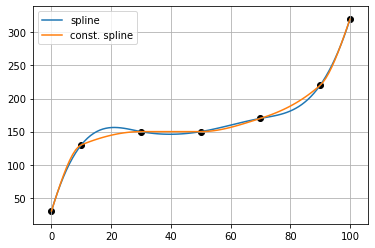

In [91]:
# make a cubic spline interpolation in between the dataset
# data for testing the formulae as used in the white paper
# The distillation curve

x = [ 0,  10,  30,  50,  70,  90, 100]
y = [30, 130, 150, 150, 170, 220, 320]

spline = interpolate.interp1d(x,y,kind='cubic')

xint = np.linspace(x[0],x[-1],100)

yint_spline = spline(xint)
yint_ccspline = ccspline(x,y,xint)

get_ipython().run_line_magic('matplotlib', 'inline')
plt.plot(xint,yint_spline,label='spline')
plt.scatter(x,y,c='k')
plt.plot(xint,yint_ccspline,label='const. spline')
plt.grid()
plt.legend()

### ccspline behaviour is satisfactory.  

### Make the geoscode to test the interpolation scheme.  

### First the Fourier file reader. 

In [92]:
def rdfous(path):
    '''
    This function reads the Fourier files.
    
    The output Fourier file has a shape:    [nmugs*nmat,nmugs,nfou]  ! This is similar to the FORTRAN code.
    '''
    #% first read the Fourier file as is.
    ff = [line.strip().split() for line in open(path)]
    # determine the starting index of the file. 
    for i,val in enumerate(ff): 
        if val[0] != '#': 
            sidx = i 
            break
    # get the number of Stokes elements
    nmat = int(ff[sidx][0])
    # get the number of Gauss elements
    nmugs = int(ff[sidx+1][0])
    # read all the angles 
    xmu = [np.float64(ff[sidx+1+i][0]) for i in range(1,nmugs+1)]
    # calculate the number of Fourier terms in the file
    nfou  = int((len(ff)-(sidx+1+1+nmugs))/(nmugs*nmugs))
    #% Read the Fourier Matrix
    rfou  = np.zeros((nmugs*nmat,nmugs,nfou)) # This matrix is designed similar to the FORTRAN version!!
    c = 0 # Initialize a counter
    for m in range(nfou):
        for i in range(nmugs):
            ibase = i*nmat
            for j in range(nmugs):
                for k in range(nmat):
                    rfou[ibase+k,j,m] = np.float64(ff[sidx+1+1+nmugs+c][3+k])
                c+=1  # Increment the counter outside the nmat loop!
    return nfou,nmat,nmugs,np.array(xmu),rfou

### Bracks to determine where mu,mu0 values lie in the Fourier file. 

In [93]:
#%% make the bracks function similar to the old geosCode
def bracks(el,array):
    '''
    This function returns the indexes i1,i2 surrounding the element "el".
    '''
    eps = 1.e-8
    if el <= (array[0]+eps):
        i1 = 1
        i2 = 1
    elif el >= (array[-1]-eps):
        i1 = len(array)-1
        i2 = len(array)-1
    else:
        for i in range(1,len(array)):
            if ((el<=(array[i]+eps))&(el>(array[i-1]-eps))):
                i1 = i - 1
                i2 = i
    return i1,i2

### Make the FORTRAN version of geosmain code. 

In [94]:
#%% Make the FORTRAN version of the geosmain code. 
def calc_Stokes(foudata,theta0,theta,phi,beta,kind='cubic'):
    '''
    Calculate Stokes Vectors given a certain set of geometries.
    '''
    # get the Fourier data nfou,nmat,nmugs,xmu,rfou
    nfou = foudata[0]
    nmat = foudata[1]
    nmugs = foudata[2]
    xmu = foudata[3]
    rfou = foudata[4]
    
    # first make sure each geometry component is passed as an array of length 1
    if np.isscalar(theta0): theta0 = np.array([theta0])
    if np.isscalar(theta): theta = np.array([theta])
    if np.isscalar(phi): phi = np.array([phi])
    if np.isscalar(beta): beta = np.array([beta])
    
    # assert that the dimension is 1
    assert len(theta0.shape) == 1
    assert len(theta.shape) == 1
    assert len(phi.shape) == 1
    assert len(beta.shape) == 1
    # assert that the length of the arrays are equal
    assert len(theta0) == len(theta)
    assert len(theta) == len(phi)
    assert len(phi) == len(beta)
    
    # array to store the Stokes values for all geometries
    SvRall = np.empty((len(theta0),nmat))
    
    for g in range(len(theta0)):
        # handle nans first
        if (np.isnan(theta0[g]))or(np.isnan(theta[g]))or(np.isnan(phi[g]))or(np.isnan(beta[g])):
            SvRall[g,0] = np.nan
            SvRall[g,1] = np.nan
            SvRall[g,2] = np.nan
            if nmat>3:
                SvRall[g,3] = np.nan
            continue
        # get the angles in cos
        mu0 = np.cos(np.deg2rad(theta0[g]))
        mu  = np.cos(np.deg2rad(theta[g]))
        
        # find the locations in array xmu where mu falls
        j1,j2 = bracks(mu,xmu)
        
        # Initialize the reflection matrix
        RM = np.zeros(nmat)
        
        # Initialize the Stokes vector
        SvR = np.zeros(nmat)
        
        # Initialize some variables
        rf = np.zeros(nmugs)
        rfm = np.zeros(nmat)
        rfj = np.zeros((nmugs,nmat))
        Bplus = np.zeros(nmat)
        
        # Loop over the Fourier Coefficients
        for m in range(nfou):
            fac = 1.
            if m == 0: fac = 0.5   
            if (j1 == j2):
                for k in range(nmat):
                    ki = (j1-1)*nmat + k
                    for i in range(nmugs):
                        rf[i] = rfou[ki,i,m]

                    if kind == 'ccspline':
                        rfm[k] = ccspline(xmu,rf,mu0)[0]
                    elif kind == 'akima':
                        spline = interpolate.Akima1DInterpolator(xmu,rf)
                        rfm[k] = spline(mu0)
                    else:
                        # make a spline interpolation object 
                        spline = interpolate.interp1d(xmu,rf,kind=kind)
                        # find the interpolated value at mu0
                        rfm[k] = spline(mu0)
                        
            else:
                for j in range(nmugs):
                    for k in range(nmat):
                        ki = j*nmat + k
                        for i in range(nmugs):
                            rf[i] = rfou[ki,i,m]
                        if kind == 'ccspline':
                            rfj[j,k] = ccspline(xmu,rf,mu0)[0]
                        elif kind == 'akima':
                            spline = interpolate.Akima1DInterpolator(xmu,rf)                            
                            rfj[j,k] = spline(mu0)
                        else:
                            # make a spline interpolation object 
                            spline = interpolate.interp1d(xmu,rf,kind=kind)
                            # find the interpolated value at mu0
                            rfj[j,k] = spline(mu0)
                           
                for k in range(nmat):
                    for i in range(nmugs):
                        rf[i] = rfj[i,k]
                    if kind == 'ccspline':
                        rfm[k] = ccspline(xmu,rf,mu)[0]
                    elif kind == 'akima':
                        spline = interpolate.Akima1DInterpolator(xmu,rf)
                        rfm[k] = spline(mu)
                    else:
                        # make a spline interpolation object 
                        spline = interpolate.interp1d(xmu,rf,kind=kind)
                        # find the interpolated value at mu
                        rfm[k] = spline(mu)
                        #rfm[k] = ccspline(xmu,rf,mu)[0]
                    
            # Calculate the local reflection matrix (only the first column)
            Bplus[0] = np.cos(m*np.deg2rad(phi[g])) 
            Bplus[1] = np.cos(m*np.deg2rad(phi[g])) 
            Bplus[2] = np.sin(m*np.deg2rad(phi[g])) 
            if nmat>3: Bplus[3] = np.sin(m*np.deg2rad(phi[g])) 
            
            for k in range(nmat):
                RM[k] = RM[k] + 2.0*Bplus[k]*fac*rfm[k]
        
        # Calculate the locally reflected Stokes vector with the matrix
        for k in range(nmat):
            apix = 1.0    # should be the area of a pixel!
            SvR[k] = 4*mu0*RM[k]*apix/np.pi
        # Rotate Stokes elements Q and U to the actual ref. plane (this is for Planet Phase calculations)
        if nmat>1:
            be = np.deg2rad(beta[g])
            SvQ = np.cos(2.0*be)*SvR[1] + np.sin(2.0*be)*SvR[2]
            SvU = -np.sin(2.0*be)*SvR[1] + np.cos(2.0*be)*SvR[2]
            SvR[1] = SvQ
            SvR[2] = SvU
            SvRall[g,0] = SvR[0]
            SvRall[g,1] = SvR[1]
            SvRall[g,2] = SvR[2]
            if nmat>3: SvRall[g,3] = SvR[3]     
    return SvRall

### Make similar geosmain code but with faster 2d interpolation scheme.  

In [95]:
#%% 
def calc_Stokes2(foudata,theta0,theta,phi,beta,kind='cubic',sig = 0):
    '''
    This function is a 2d interpolation scheme based Stokes calculator.
    '''
    # get the Fourier data nfou,nmat,nmugs,xmu,rfou
    nfou = foudata[0]
    nmat = foudata[1]
    nmugs = foudata[2]
    xmu = foudata[3]
    rfou = foudata[4]
    
    # first make sure each geometry component is passed as an array of length 1
    if np.isscalar(theta0): theta0 = np.array([theta0])
    if np.isscalar(theta): theta = np.array([theta])
    if np.isscalar(phi): phi = np.array([phi])
    if np.isscalar(beta): beta = np.array([beta])
    
    # assert that the dimension is 1
    assert len(theta0.shape) == 1
    assert len(theta.shape) == 1
    assert len(phi.shape) == 1
    assert len(beta.shape) == 1
    # assert that the length of the arrays are equal
    assert len(theta0) == len(theta)
    assert len(theta) == len(phi)
    assert len(phi) == len(beta)
    
    # array to store the Stokes values for all geometries
    SvRall = np.empty((len(theta0),nmat))
    
    for g in range(len(theta0)):
        #print("Geometry no.: ",g)
        # handle nans first
        if (np.isnan(theta0[g]))or(np.isnan(theta[g]))or(np.isnan(phi[g]))or(np.isnan(beta[g])):
            SvRall[g,0] = np.nan
            SvRall[g,1] = np.nan
            SvRall[g,2] = np.nan
            if nmat>3:
                SvRall[g,3] = np.nan
            continue
        # get the angles in cos
        mu0 = np.cos(np.deg2rad(theta0[g]))
        mu  = np.cos(np.deg2rad(theta[g]))
        #print('mu0 =',mu0)
        #print('mu =',mu)
        
        # find the locations in array xmu where mu falls
        j1,j2 = bracks(mu,xmu)
        
        # Initialize the reflection matrix
        RM = np.zeros(nmat)
        
        # Initialize the Stokes vector
        SvR = np.zeros(nmat)
        
        # Initialize some variables
        rf = np.zeros(nmugs)
        rfm = np.zeros(nmat)
        rfj = np.zeros((nmugs,nmat))
        Bplus = np.zeros(nmat)
        
        # Loop over the Fourier Coefficients
        for m in range(nfou):
            fac = 1.
            if m == 0: fac = 0.5
            
            # perform a 2d interpolation across mu and mu0
            # for nmat = 0,1,2,3.
            intfunc0 = interpolate.interp2d(xmu,xmu,gaussian_filter(rfou[0::nmat,:,m],sigma=sig),kind=kind)
            intfunc1 = interpolate.interp2d(xmu,xmu,gaussian_filter(rfou[1::nmat,:,m],sigma=sig),kind=kind)
            intfunc2 = interpolate.interp2d(xmu,xmu,gaussian_filter(rfou[2::nmat,:,m],sigma=sig),kind=kind)
            if nmat>3: intfunc3 = interpolate.interp2d(xmu,xmu,gaussian_filter(rfou[3::nmat,:,m],sigma=sig),kind=kind)
        
            # find the value of mu,mu0 at each nmat
            rfm[0] = intfunc0(mu,mu0)
            rfm[1] = intfunc1(mu,mu0)
            rfm[2] = intfunc2(mu,mu0)
            if nmat>3: rfm[3] = intfunc3(mu,mu0)
                
            # Calculate the local reflection matrix (only the first column)
            Bplus[0] = np.cos(m*np.deg2rad(phi[g])) 
            Bplus[1] = np.cos(m*np.deg2rad(phi[g])) 
            Bplus[2] = np.sin(m*np.deg2rad(phi[g])) 
            if nmat>3: Bplus[3] = np.sin(m*np.deg2rad(phi[g]))   # for V
                         
            for k in range(nmat):
                RM[k] = RM[k] + 2.0*Bplus[k]*fac*rfm[k]
         
        # Calculate the locally reflected Stokes vector with the matrix
        for k in range(nmat):
            apix = 1.0    # should be the area of a pixel!
            SvR[k] = 4*mu0*RM[k]*apix/np.pi
        # Rotate Stokes elements Q and U to the actual ref. plane (this is for Planet Phase calculations)
        if nmat>1:
            be = np.deg2rad(beta[g])
            SvQ = np.cos(2.0*be)*SvR[1] + np.sin(2.0*be)*SvR[2]
            SvU = -np.sin(2.0*be)*SvR[1] + np.cos(2.0*be)*SvR[2]
            SvR[1] = SvQ
            SvR[2] = SvU
            SvRall[g,0] = SvR[0]
            SvRall[g,1] = SvR[1]
            SvRall[g,2] = SvR[2]
            if nmat>3:
                SvRall[g,3] = SvR[3]        
    return SvRall

### Make a disc with 50 pixels and calculate the geometries.  

In [96]:
#%% get the x,y coordinates of projection of the disc
x,y = makedisc(50)
#% calculate the geometries from the x and y coordinates used for the GEOS code to create the disc 
theta,theta0,phi,lat,lon,beta = calcPlanetGeometry(x,y,0.0,50)

/Users/gouravmahapatr/Dropbox/PhD/Codes/PythonCodes/getgeos.py:33: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1-x**2-y**2)


### Print the geometries at the equator. 

In [97]:
print('theta = ',theta[25,::5])  # in steps of 5.
print('theta0 =',theta0[25,::5])

theta =  [        nan 52.76684902 36.31246474 22.84825112 10.64969247  1.65387188
 13.02731407 25.40773381 39.27048369 56.82294607]
theta0 = [        nan 52.76684902 36.31246474 22.84825112 10.64969247  1.65387188
 13.02731407 25.40773381 39.27048369 56.82294607]


### Reproduce the rings with a Fourier file having 40 Gauss points and a simplistic Venus atmosphere. 

In [98]:
path40 = '/Users/gouravmahapatr/Dropbox/PhD/Codes/geosMaster/fougp40.dat'

# Read the Fourier file and print the shape of the outputs.
nfou,nmat,nmugs,xmu,rfou = rdfous(path=path40)
foudata = rdfous(path=path40)
print('Fourier file shape: ',rfou.shape)
print('nfou: ',nfou)
print('nmat: ',nmat)
print('nmugs: ',nmugs)
print('len(xmu)',len(xmu))

Fourier file shape:  (123, 41, 62)
nfou:  62
nmat:  3
nmugs:  41
len(xmu) 41


### Use the 1d spline interpolation based function to calculate the Stokes vector 

In [99]:
# use the 2d interpolation based function with spline interpolation 
stokes = calc_Stokes(foudata,theta0.flatten(),theta.flatten(),phi.flatten(),beta.flatten(),kind='cubic')
stokes = stokes.reshape([50,50,3])

Text(0.5, 1.0, 'DOLP')

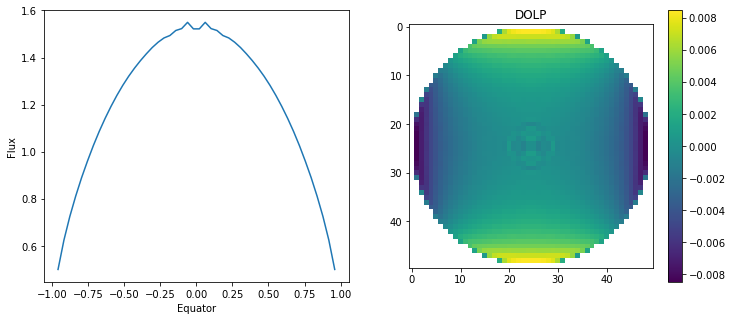

In [100]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(np.linspace(-1,1,len(stokes[25,:,0])),stokes[25,:,0])
plt.xlabel('Equator')
plt.ylabel('Flux')
plt.subplot(122)
plt.imshow(-stokes[:,:,1]/stokes[:,:,0])
plt.colorbar()
plt.title('DOLP')

### Use the 2d spline interpolation based function to calculate the Stokes vector

In [101]:
# use the 2d interpolation based function with spline interpolation 
stokes = calc_Stokes2(foudata,theta0.flatten(),theta.flatten(),phi.flatten(),beta.flatten(),kind='cubic')
stokes = stokes.reshape([50,50,3])

Text(0.5, 1.0, 'Flux')

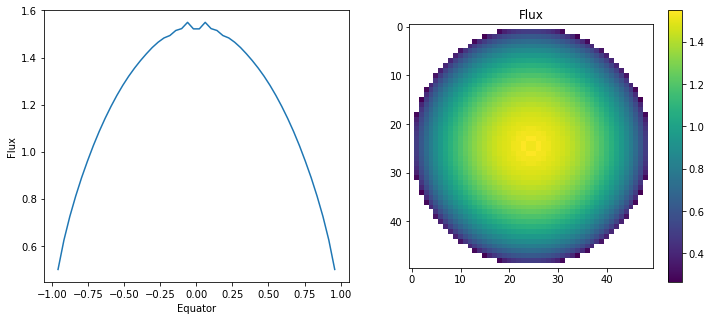

In [102]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(np.linspace(-1,1,len(stokes[25,:,0])),stokes[25,:,0])
plt.xlabel('Equator')
plt.ylabel('Flux')
plt.subplot(122)
plt.imshow(stokes[:,:,0])#/stokes[:,:,0])
plt.colorbar()
plt.title('Flux')

### View the region of Fourier files where the interpolation problem occurs and compare with the Fourier file with 100 Gauss points. 

In [103]:
rfou.shape

(123, 41, 62)

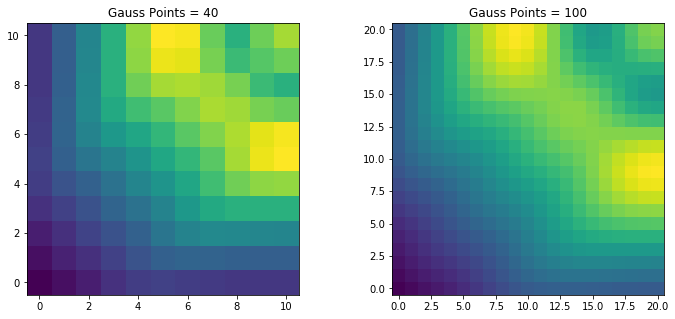

In [104]:
# get the path to the file with 100 Gauss points. 
path100 = '/Users/gouravmahapatr/Dropbox/PhD/Codes/geosMaster/fougp100.dat'

rfouI = rfou[0::3,:,0]
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.imshow(np.log10(rfouI[30:,30:]),origin='lower')
plt.title('Gauss Points = 40')
plt.subplot(122)
_,_,_,_,rfou100 = rdfous(path = path100)
rfouI100 = rfou100[0::3,:,0]
plt.title('Gauss Points = 100')
plt.imshow(np.log10(rfouI100[80:,80:]),origin='lower')

### Plot the 1d flux for GP 40 and GP 100 

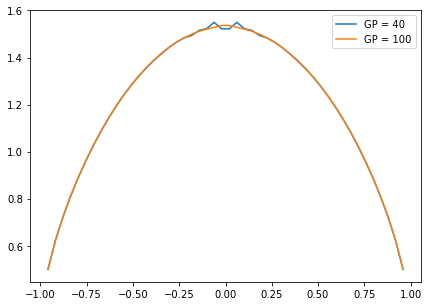

In [105]:
stokes1 = calc_Stokes2(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],kind='cubic')
stokes2 = calc_Stokes2(rdfous(path100),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],kind='cubic')

plt.figure(figsize=[7,5])
plt.subplot(111)
plt.plot(np.linspace(-1,1,len(stokes1[:,0])),stokes1[:,0],label='GP = 40')
plt.plot(np.linspace(-1,1,len(stokes2[:,0])),stokes2[:,0],label='GP = 100')
plt.legend()

### Perform interpolations with constrained cubic spline, spline and akima and compare 

/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


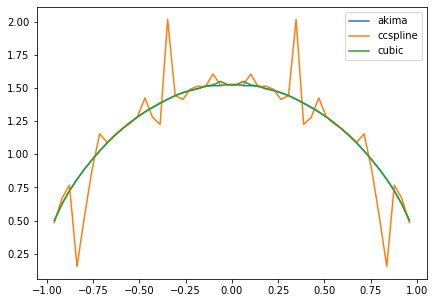

In [106]:
stokesak = calc_Stokes(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],kind='akima')
stokescc = calc_Stokes(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],kind='ccspline')

plt.figure(figsize=[7,5])
plt.subplot(111)
plt.plot(np.linspace(-1,1,len(stokesak[:,0])),stokesak[:,0],label='akima')
plt.plot(np.linspace(-1,1,len(stokescc[:,0])),stokescc[:,0],label='ccspline')
plt.plot(np.linspace(-1,1,len(stokes1[:,0])),stokes1[:,0],label='cubic')
plt.legend()

(1.15, 1.4)

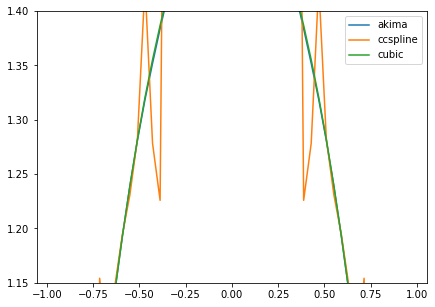

In [107]:
plt.figure(figsize=[7,5])
plt.subplot(111)
plt.plot(np.linspace(-1,1,len(stokesak[:,0])),stokesak[:,0],label='akima')
plt.plot(np.linspace(-1,1,len(stokescc[:,0])),stokescc[:,0],label='ccspline')
plt.plot(np.linspace(-1,1,len(stokes1[:,0])),stokes1[:,0],label='cubic')
plt.legend()
plt.ylim([1.15,1.4])

### Use Gaussian filter to smooth the Fourier files.  

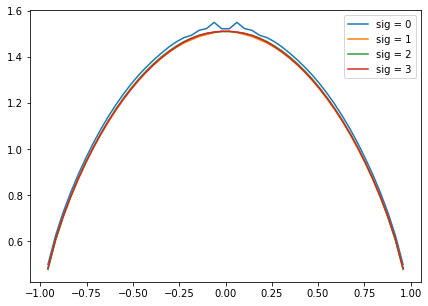

In [108]:
plt.figure(figsize=[7,5])
plt.subplot(111)
stokes = calc_Stokes2(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],sig=0)
plt.plot(np.linspace(-1,1,len(stokes[:,0])),stokes[:,0],label='sig = 0')
stokes = calc_Stokes2(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],sig=1)
plt.plot(np.linspace(-1,1,len(stokes[:,0])),stokes[:,0],label='sig = 1')
stokes = calc_Stokes2(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],sig=2)
plt.plot(np.linspace(-1,1,len(stokes[:,0])),stokes[:,0],label='sig = 2')
stokes = calc_Stokes2(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],sig=3)
plt.plot(np.linspace(-1,1,len(stokes[:,0])),stokes[:,0],label='sig = 3')
plt.legend()

### Plot the whole planet 

In [109]:
stokes = calc_Stokes2(rdfous(path40),theta0.flatten(),theta.flatten(),phi.flatten(),beta.flatten(),sig=3)
stokes = stokes.reshape([50,50,3])

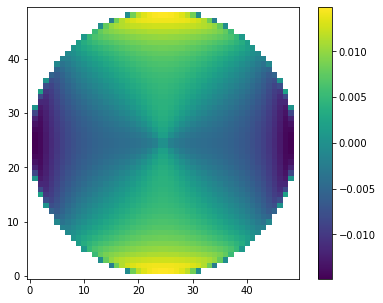

In [110]:
plt.figure(figsize=[7,5])
plt.imshow(-stokes[:,:,1]/stokes[:,:,0],origin='lower')
plt.colorbar()

### Try other phase angles 

In [114]:
#%% get the x,y coordinates of projection of the disc
x,y = makedisc(50)
#% calculate the geometries from the x and y coordinates used for the GEOS code to create the disc 
theta,theta0,phi,lat,lon,beta = calcPlanetGeometry(x,y,30.0,50)
stokes = calc_Stokes2(rdfous(path40),theta0.flatten(),theta.flatten(),phi.flatten(),beta.flatten(),sig=3)
stokes = stokes.reshape([50,50,3])

/Users/gouravmahapatr/Dropbox/PhD/Codes/PythonCodes/getgeos.py:33: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1-x**2-y**2)


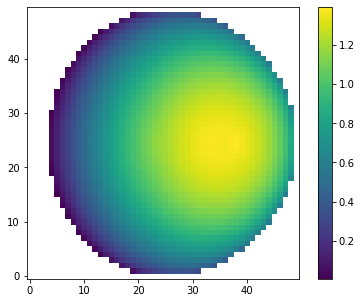

In [116]:
plt.figure(figsize=[7,5])
plt.imshow(np.rot90(stokes[:,:,0]),origin='lower')
plt.colorbar()

In [117]:
#stokescc = calc_Stokes(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],kind='ccspline')
stokes = calc_Stokes(rdfous(path40),theta0[25,:],theta[25,:],phi[25,:],beta[25,:],kind='spline')

/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


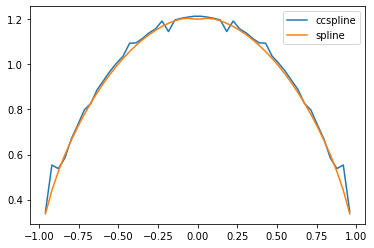

In [125]:
plt.plot(np.linspace(-1,1,len(stokescc[:,0])),stokescc[:,0],label='ccspline')
plt.plot(np.linspace(-1,1,len(stokes[25,:,0])),stokes[25,:,0],label='spline')
plt.legend()